### Agent state and action definition
* State Variable: x = [w, n, M, g_lag, e, s, (H, r, m), O_lag], actions variable a = [c, b, k, i, q] both of them are numpy array. 

In [1]:
%pylab inline
from scipy.interpolate import interpn
from sklearn.neighbors import KNeighborsRegressor as KN
from helpFunctions import surfacePlot
import numpy as np
from scipy import optimize
from multiprocessing import Pool
from functools import partial
import warnings
import math
from numba import jit, float64, int32, guvectorize
warnings.filterwarnings("ignore")
np.printoptions(precision=2)


# time line
T_min = 0
T_max = 70
T_R = 45
# discounting factor
beta = 1/(1+0.02)
# utility function parameter 
gamma = 2
# relative importance of housing consumption and non durable consumption 
alpha = 0.8
# parameter used to calculate the housing consumption 
kappa = 0.3
# depreciation parameter 
delta = 0.05
# housing parameter 
chi = 0.3
# uB associated parameter
B = 2
# # minimum consumption 
# c_bar = 3
# constant cost 
c_h = 2
# All the money amount are denoted in thousand dollars
earningShock = [0.8,1.2]
# Define transition matrix of economical states
# GOOD -> GOOD 0.8, BAD -> BAD 0.6
Ps = np.array([[0.6, 0.4],[0.2, 0.8]])
# current risk free interest rate
r_b = np.array([0.01 ,0.03])
# stock return depends on current and future econ states
# r_k = np.array([[-0.2, 0.15],[-0.15, 0.2]])
r_k = np.array([[-0.15, 0.20],[-0.15, 0.20]])
# expected return on stock market
# r_bar = 0.0667
r_bar = 0.02
# probability of survival
Pa = np.load("prob.npy")
# deterministic income
detEarning = np.load("detEarning.npy")
# probability of employment transition Pe[s, s_next, e, e_next]
Pe = np.array([[[[0.3, 0.7], [0.1, 0.9]], [[0.25, 0.75], [0.05, 0.95]]],
               [[[0.25, 0.75], [0.05, 0.95]], [[0.2, 0.8], [0.01, 0.99]]]])
# tax rate before and after retirement
tau_L = 0.2
tau_R = 0.1

# constant state variables: Purchase value 250k, down payment 50k, mortgage 200k, interest rate 3.6%,
# 55 payment period, 8.4k per period. One housing unit is roughly 1 square feet. Housing price 0.25k/sf 

# some variables associate with 401k amount
Nt = [np.sum(Pa[t:]) for t in range(T_max-T_min)]
Dt = [np.ceil(((1+r_bar)**N - 1)/(r_bar*(1+r_bar)**N)) for N in Nt]
# owning a house 
O_lag = 1
# housing unit
H = 1000
# mortgate rate 
rh = 0.036
# mortgate payment 
m = 8.4
# housing price constant 
pt = 250/1000
# 30k rent 1000 sf
pr = 30/1000

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Define the utility function
def u(c):
    # shift utility function to the left, so it only takes positive value
    return (np.float_power(c, 1-gamma) - 1)/(1 - gamma)

#Define the bequeath function, which is a function of wealth
def uB(tb):
    return B*u(tb)

#Calcualte HE 
def calHE(x):
    w, n, M, g_lag, e, s = x
    HE = (H+(1-chi)*(1-delta)*g_lag)*pt - M
    return HE

#Calculate TB 
def calTB(x):
    w, n, M, g_lag, e, s = x
    TB = w + n + calHE(x)
    return TB

def R(x, a):
    '''
    Input:
        state x: w, n, M, g_lag, e, s
        action a: c, b, k, i, q
    Output: 
        reward value
    '''
    w, n, M, g_lag, e, s = x
    c, b, k, i, q = a
    if q == 1:
        h = H + (1-delta)*g_lag + i
        Vh = (1+kappa)*h
    else:
        h = H + (1-delta)*g_lag
        Vh = (1-kappa)*(h-(1-q)*H)
    C = np.float_power(c, alpha) * np.float_power(Vh, 1-alpha) 
    return u(C)

#Define the earning function, which applies for both employment and unemployment, good econ state and bad econ state 
def y(t, x):
    w, n, M, g_lag, e, s = x
    if t <= T_R:
        welfare = 5
        return detEarning[t] * earningShock[int(s)] * e + (1-e) * welfare
    else:
        return detEarning[t]
    
#Earning after tax and fixed by transaction in and out from 401k account 
def yAT(t,x):
    yt = y(t, x)
    w, n, M, g_lag, e, s = x
    if t <= T_R and e == 1:
        # 5% of the income will be put into the 401k 
        i = 0.05
        return (1-tau_L)*(yt * (1-i))
    if t <= T_R and e == 0:
        return yt
    else:
        # t > T_R, n/discounting amount will be withdraw from the 401k 
        return (1-tau_R)*yt + n/Dt[t]
    
#Define the evolution of the amount in 401k account 
def gn(t, n, x, s_next):
    w, n, M, g_lag, e, s = x
    if t <= T_R and e == 1:
        # if the person is employed, then 5 percent of his income goes into 401k 
        i = 0.05
        n_cur = n + y(t, x) * i
    elif t <= T_R and e == 0:
        # if the perons is unemployed, then n does not change 
        n_cur = n
    else:
        # t > T_R, n/discounting amount will be withdraw from the 401k 
        n_cur = n - n/Dt[t]
    return (1+r_k[int(s), s_next])*n_cur 

def transition(x, a, t):
    '''
    Input: state and action and time
    Output: possible future states and corresponding probability 
    '''
    w, n, M, g_lag, e, s = x
    c, b, k, i, q = a
    # variables used to collect possible states and probabilities
    x_next = []
    prob_next = []
    M_next = M*(1+rh) - m
    if q == 1:
        g = (1-delta)*g_lag + i
    else:
        g = (1-delta)*g_lag
    for s_next in [0,1]:
        w_next =  b*(1+r_b[int(s)]) + k*(1+r_k[int(s), s_next])
        n_next = gn(t, n, x, s_next)
        if t >= T_R:
            e_next = 0
            x_next.append([w_next, n_next, M_next, g, s_next, e_next])
            prob_next.append(Ps[int(s),s_next])
        else:
            for e_next in [0,1]:
                x_next.append([w_next, n_next, M_next, g, s_next, e_next])
                prob_next.append(Ps[int(s),s_next] * Pe[int(s),s_next,int(e),e_next])
    return np.array(x_next), np.array(prob_next)

In [3]:
# Value function is a function of state and time t < T
def V(x, t, NN):
    w, n, M, g_lag, e, s = x
    yat = yAT(t,x)
    if t == T_max-1:
        # The objective functions of terminal state 
        def obj1(cbki):
            # Not renting out case 
            q = 1
            c,b,k,i = cbki
            a = [c, b, k, i, q]
            x_next, p_next  = transition(x, a, t)
            TB_next = list(map(calTB, x_next)) # conditional on being dead in the future
            uBTB = np.vectorize(uB)(TB_next)
            return R(x, a) + beta * np.dot(uBTB, p_next)
        
        def obj2(cbkq):
            # Renting out case 
            i = 0
            c,b,k,q = cbkq
            a = [c, b, k, i, q]
            x_next, p_next  = transition(x, a, t)
            TB_next = list(map(calTB, x_next)) # conditional on being dead in the future
            uBTB = np.vectorize(uB)(TB_next)
            return R(x, a) + beta * np.dot(uBTB, p_next)
        
    else:
        # The objective functions are functions of actions
        def obj1(cbki):
            # Not renting out case 
            q = 1
            c,b,k,i = cbki
            a = [c, b, k, i, q]
            x_next, p_next  = transition(x, a, t)
            V_tilda = NN.predict(x_next) # V_{t+1} conditional on being alive, approximation here 
            TB_next = list(map(calTB, x_next)) # conditional on being dead in the future
            uBTB = np.vectorize(uB)(TB_next)
            return R(x, a) + beta * (Pa[t] * np.dot(V_tilda, p_next)) + (1 - Pa[t]) * np.dot(uBTB, p_next)

        def obj2(cbkq):
            # Renting out case 
            i = 0
            c,b,k,q = cbkq
            a = [c, b, k, i, q]
            x_next, p_next  = transition(x, a, t)
            V_tilda = NN.predict(x_next) # V_{t+1} conditional on being alive, approximation here
            TB_next = list(map(calTB, x_next)) # conditional on being dead in the future
            uBTB = np.vectorize(uB)(TB_next)
            return R(x, a) + beta * (Pa[t] * np.dot(V_tilda, p_next)) + (1 - Pa[t]) * np.dot(uBTB, p_next)
    
    def obj1_solver(obj1):
    # Constrain: yat + w - m = c + b + k + (1+chi)*i*pt + I{i>0}*c_h
    # i_portion takes [0:0.05:0.95]
    # c_portion takes remaining [0:0.05:0.95]
    # b_portion takes reamining [0:0.05:0.95]
    # k is the remainder 
        mfun = -np.inf 
        ma = [0,0,0,0]
        for ip in np.linspace(0,0.9,10):
            budget1 = yat + w - m
            if ip*budget1 > c_h:
                i = (budget1*ip - c_h)/((1+chi)*pt)
                budget2 = budget1 * (1-ip)
            else:
                i = 0
                budget2 = budget1
            for cp in np.linspace(0,1,6):
                c = budget2*cp
                budget3 = budget2 * (1-cp)
                for bp in np.linspace(0,1,3):
                    b = budget3* bp
                    k = budget3 * (1-bp)
                    a = [c,b,k,i]
                    fun = obj1(a)
                    if fun > mfun:
                        mfun = fun
                        ma = a
        return fun, ma

    def obj2_solver(obj2):
    # Constrain: yat + w - m + (1-q)*H*pr = c + b + k
    # q takes value [0:0.05:0.95]
    # c_portion takes remaining [0:0.05:0.95]
    # b_portion takes reamining [0:0.05:0.95]
    # k is the remainder  
        mfun = -np.inf 
        ma = [0,0,0,1]
        for q in np.linspace(0,1,11):
            budget1 = yat + w - m + (1-q)*H*pr
            for cp in np.linspace(0,1,6):
                c = budget1*cp
                budget2 = budget1 * (1-cp)
                for bp in np.linspace(0,1,3):
                    b = budget2* bp
                    k = budget2 * (1-bp)
                    a = [c,b,k,q]
                    fun = obj2(a)
                    if fun > mfun:
                        mfun = fun
                        ma = a
        return fun, ma
    
    fun1, action1 = obj1_solver(obj1)
    fun2, action2 = obj2_solver(obj2)
    
    if fun1 > fun2:
        c, b, k, i = action1
        q = 1
        return np.array([fun1, [c,b,k,i,q]])
    else:
        c, b, k, q = action2
        i = 0
        return np.array([fun2, [c,b,k,i,q]])

In [50]:
# wealth discretization 
w_grid_size = 5
w_lower = 10
w_upper = 10000
# 401k amount discretization 
n_grid_size = 5
n_lower = 10
n_upper = 6000
power = 2
# Mortgage amount 
Ms = np.array([50, 100, 150, 200])
M_grid_size = len(Ms)
# Improvement amount 
gs = np.array([10, 20, 100, 200])
g_grid_size = len(gs)

def powspace(start, stop, power, num):
    start = np.power(start, 1/float(power))
    stop = np.power(stop, 1/float(power))
    return np.power(np.linspace(start, stop, num=num), power)
ws = powspace(w_lower, w_upper, power, w_grid_size)
ns = powspace(n_lower, n_upper, power, n_grid_size)

xgrid = np.array([[w, n, M, g_lag, e, s] 
                            for w in ws
                            for n in ns
                            for M in Ms
                            for g_lag in gs 
                            for e in [0,1]
                            for s in [0,1]
                            ]).reshape((w_grid_size, n_grid_size,M_grid_size,g_grid_size,2,2,6))

Vgrid = np.zeros((w_grid_size, n_grid_size,M_grid_size,g_grid_size,2,2, T_max))
cgrid = np.zeros((w_grid_size, n_grid_size,M_grid_size,g_grid_size,2,2, T_max))
bgrid = np.zeros((w_grid_size, n_grid_size,M_grid_size,g_grid_size,2,2, T_max))
kgrid = np.zeros((w_grid_size, n_grid_size,M_grid_size,g_grid_size,2,2, T_max))
igrid = np.zeros((w_grid_size, n_grid_size,M_grid_size,g_grid_size,2,2, T_max))
qgrid = np.zeros((w_grid_size, n_grid_size,M_grid_size,g_grid_size,2,2, T_max))

### SLSQP with KNN approximation and multidimensional interpolation

In [5]:
class kApproxy(object):
    def __init__(self, xgrid, Vgrid):
        self.predictors = [[KN(n_neighbors=2**4, weights = 'distance') for e in [0,1]] for s in [0,1]]
        for e in [0,1]:
            for s in [0,1]:
                self.predictors[s][e].fit(xgrid[:,:,:,:,e,s,:4].reshape((w_grid_size*n_grid_size*M_grid_size*g_grid_size,4)), 
                                        Vgrid[:,:,:,:,e,s].reshape((w_grid_size*n_grid_size*M_grid_size*g_grid_size)))   
    def predict(self, x_next):
        pvalues = []
        for xx in x_next:
            pvalues.append(self.predictors[int(xx[5])][int(xx[4])].predict([xx[:4]])[0])
        return pvalues
    
class iApproxy(object):
    def __init__(self, points, Vgrid):
        self.V = Vgrid 
        self.p = points
    def predict(self, x_next):
        pvalues = []
        for xx in x_next:
            pvalues.append(interpn(self.p, self.V[:,:,:,:,int(xx[4]),int(xx[5])], xx[:4], bounds_error = False, fill_value = None)[0])
        return pvalues

### Value iteration with interpolation approximation

In [6]:
%%time
# value iteration part 
xs = xgrid.reshape((w_grid_size*n_grid_size*M_grid_size*g_grid_size*2*2,6))
pool = Pool()
points = (ws,ns,Ms,gs)
for t in range(T_max-1, T_min-1, -1):
    print(t)
    if t == T_max - 1:
        f = partial(V, t = t, NN = None)
        results = np.array(pool.map(f, xs))
    else:
        approx = iApproxy(points,Vgrid[:,:,:,:,:,:,t+1])
        f = partial(V, t = t, NN = approx)
        results = np.array(pool.map(f, xs))
    Vgrid[:,:,:,:,:,:,t] = results[:,0].reshape((w_grid_size,n_grid_size,M_grid_size,g_grid_size,2,2))
    cgrid[:,:,:,:,:,:,t] = np.array([r[0] for r in results[:,1]]).reshape((w_grid_size,n_grid_size,M_grid_size,g_grid_size,2,2))
    bgrid[:,:,:,:,:,:,t] = np.array([r[1] for r in results[:,1]]).reshape((w_grid_size,n_grid_size,M_grid_size,g_grid_size,2,2))
    kgrid[:,:,:,:,:,:,t] = np.array([r[2] for r in results[:,1]]).reshape((w_grid_size,n_grid_size,M_grid_size,g_grid_size,2,2))
    igrid[:,:,:,:,:,:,t] = np.array([r[3] for r in results[:,1]]).reshape((w_grid_size,n_grid_size,M_grid_size,g_grid_size,2,2))
    qgrid[:,:,:,:,:,:,t] = np.array([r[4] for r in results[:,1]]).reshape((w_grid_size,n_grid_size,M_grid_size,g_grid_size,2,2))
pool.close()

np.save("Vgrid_i", Vgrid)
np.save("cgrid_i", cgrid)
np.save("bgrid_i", bgrid)
np.save("kgrid_i", kgrid)
np.save("igrid_i", igrid)
np.save("qgrid_i", qgrid)

69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0
CPU times: user 47.9 s, sys: 15.8 s, total: 1min 3s
Wall time: 3h 36min 55s


### Value iteration with KNN approximation

In [9]:
%%time
# value iteration part 
xs = xgrid.reshape((w_grid_size*n_grid_size*M_grid_size*g_grid_size*2*2,6))
pool = Pool()

for t in range(T_max-1, T_min-1, -1):
    print(t)
    if t == T_max - 1:
        f = partial(V, t = t, NN = None)
        results = np.array(pool.map(f, xs))
    else:
        approx = kApproxy(xgrid,Vgrid[:,:,:,:,:,:,t+1])
        f = partial(V, t = t, NN = approx)
        results = np.array(pool.map(f, xs))
    Vgrid[:,:,:,:,:,:,t] = results[:,0].reshape((w_grid_size,n_grid_size,M_grid_size,g_grid_size,2,2))
    cgrid[:,:,:,:,:,:,t] = np.array([r[0] for r in results[:,1]]).reshape((w_grid_size,n_grid_size,M_grid_size,g_grid_size,2,2))
    bgrid[:,:,:,:,:,:,t] = np.array([r[1] for r in results[:,1]]).reshape((w_grid_size,n_grid_size,M_grid_size,g_grid_size,2,2))
    kgrid[:,:,:,:,:,:,t] = np.array([r[2] for r in results[:,1]]).reshape((w_grid_size,n_grid_size,M_grid_size,g_grid_size,2,2))
    igrid[:,:,:,:,:,:,t] = np.array([r[3] for r in results[:,1]]).reshape((w_grid_size,n_grid_size,M_grid_size,g_grid_size,2,2))
    qgrid[:,:,:,:,:,:,t] = np.array([r[4] for r in results[:,1]]).reshape((w_grid_size,n_grid_size,M_grid_size,g_grid_size,2,2))
pool.close()

np.save("Vgrid_k", Vgrid)
np.save("cgrid_k", cgrid)
np.save("bgrid_k", bgrid)
np.save("kgrid_k", kgrid)
np.save("igrid_k", igrid)
np.save("qgrid_k", qgrid)

50
50


<Figure size 432x288 with 0 Axes>

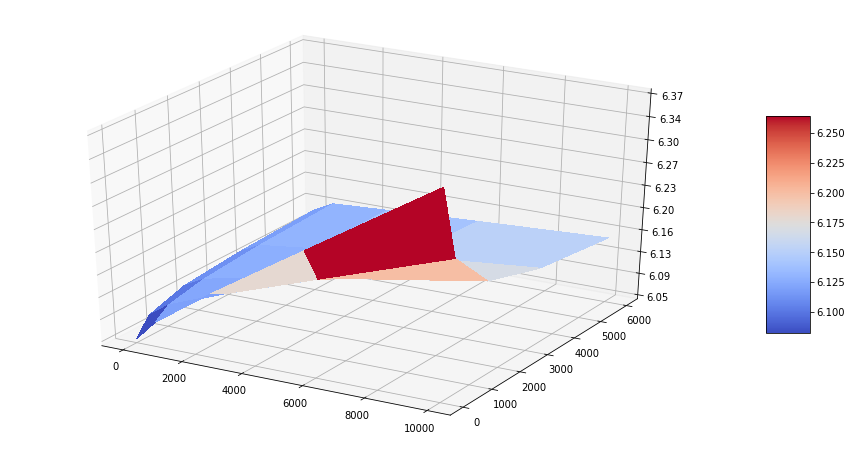

50
100


<Figure size 432x288 with 0 Axes>

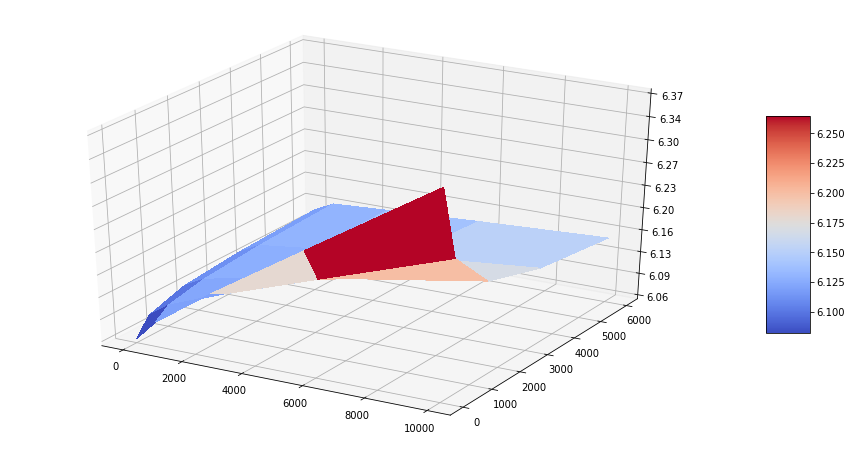

50
150


<Figure size 432x288 with 0 Axes>

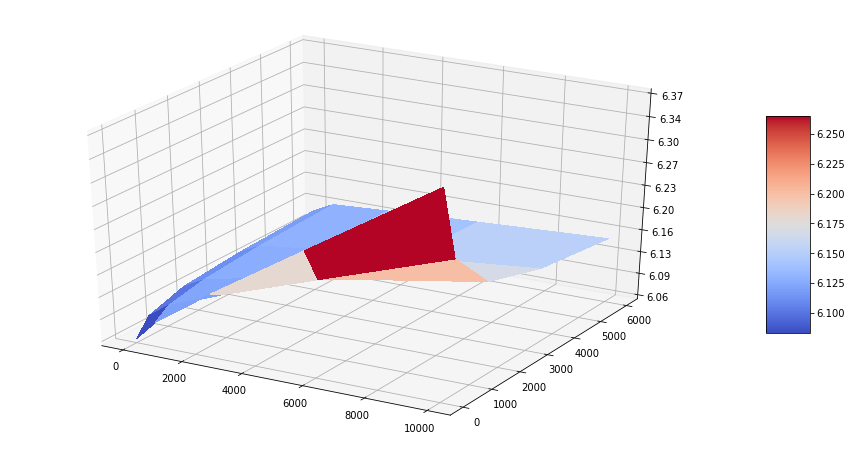

50
200


<Figure size 432x288 with 0 Axes>

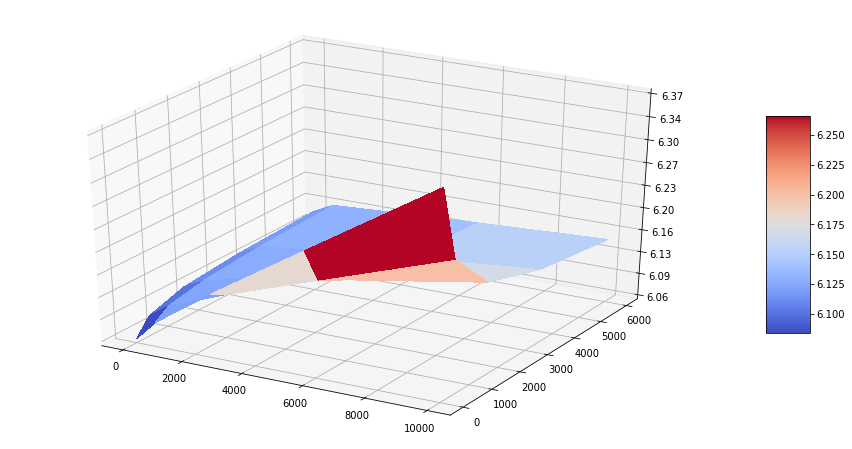

100
50


<Figure size 432x288 with 0 Axes>

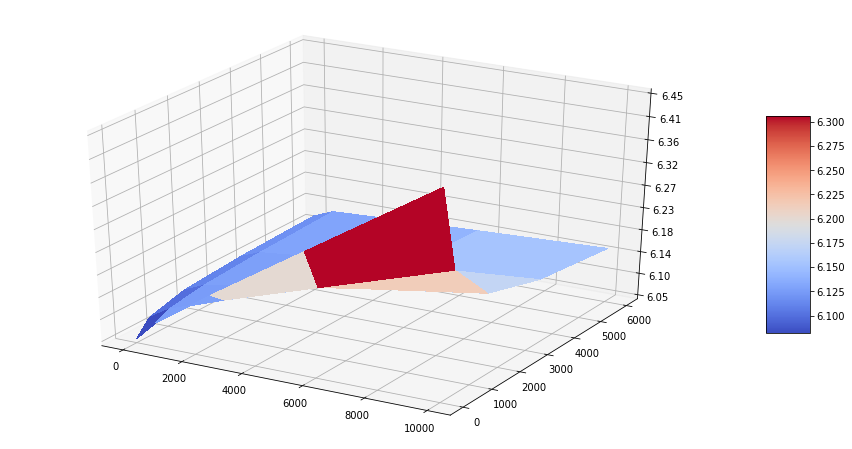

100
100


<Figure size 432x288 with 0 Axes>

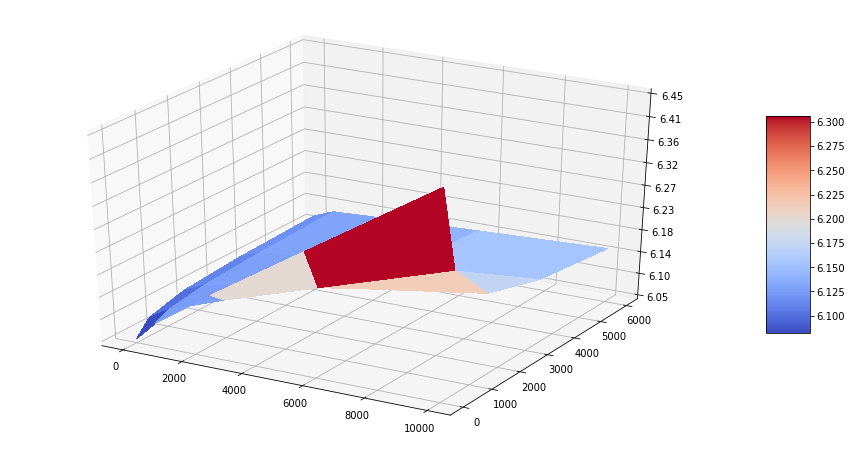

100
150


<Figure size 432x288 with 0 Axes>

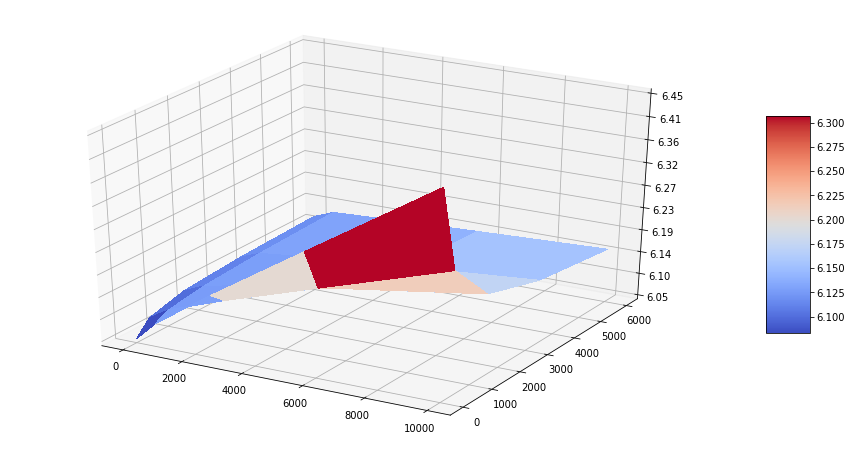

100
200


<Figure size 432x288 with 0 Axes>

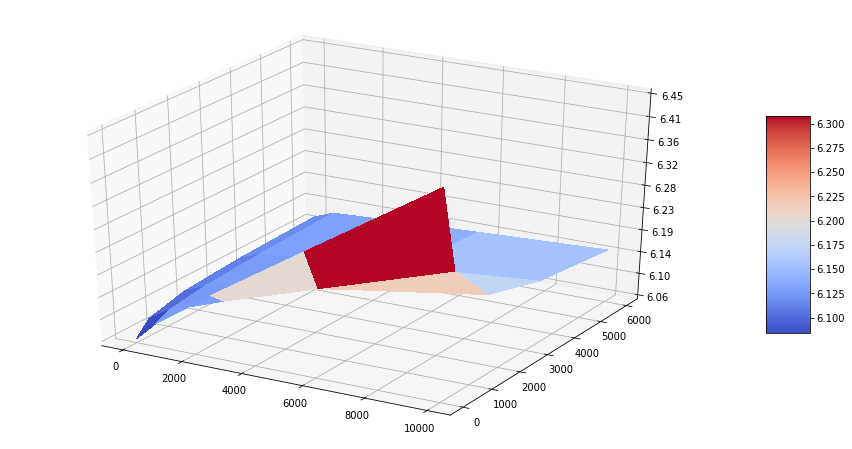

150
50


<Figure size 432x288 with 0 Axes>

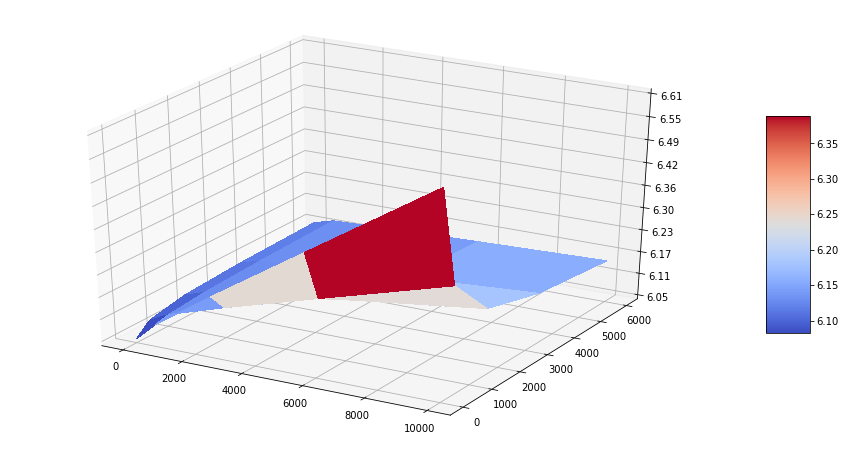

150
100


<Figure size 432x288 with 0 Axes>

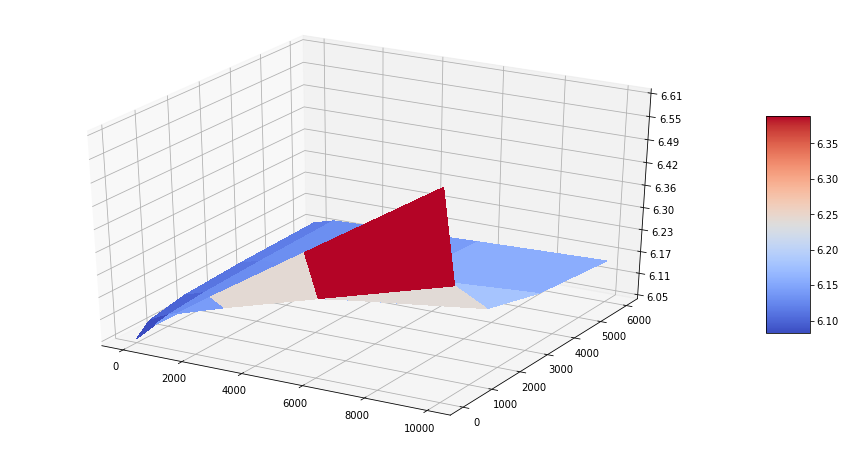

150
150


<Figure size 432x288 with 0 Axes>

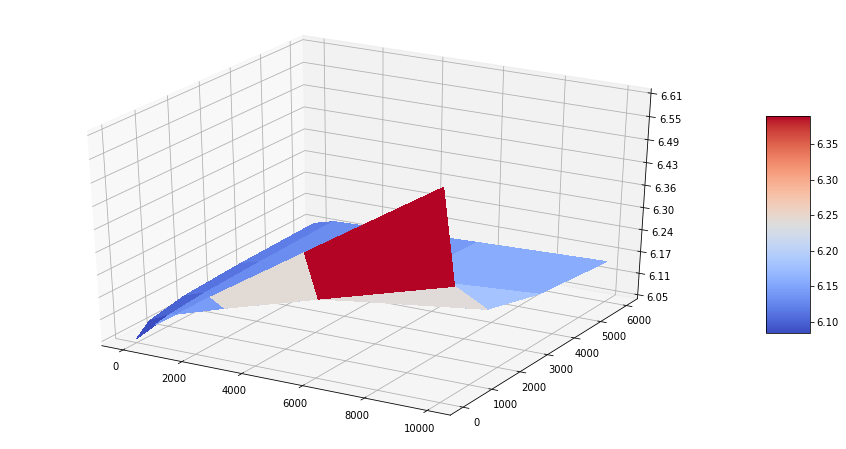

150
200


<Figure size 432x288 with 0 Axes>

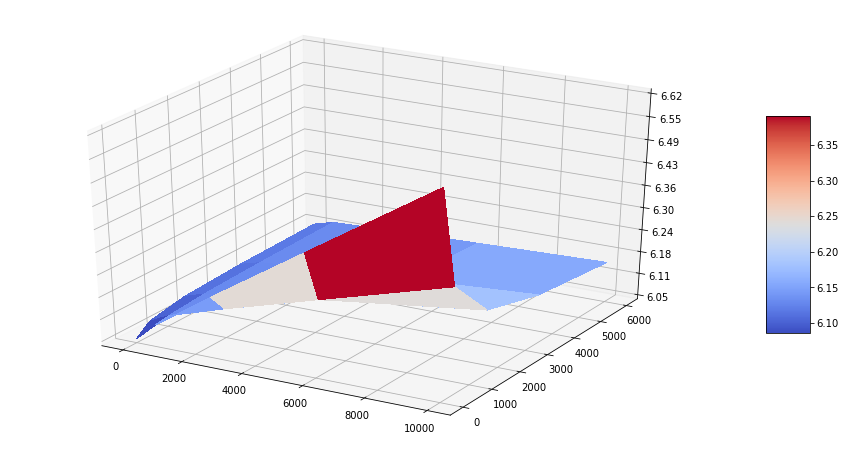

200
50


<Figure size 432x288 with 0 Axes>

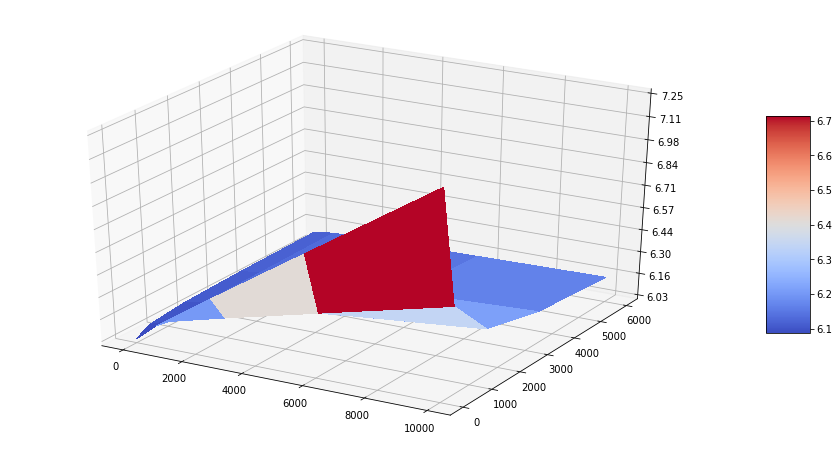

200
100


<Figure size 432x288 with 0 Axes>

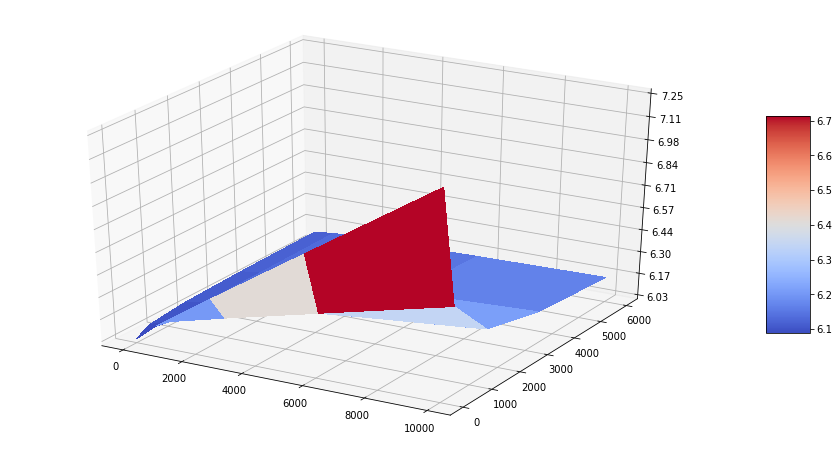

200
150


<Figure size 432x288 with 0 Axes>

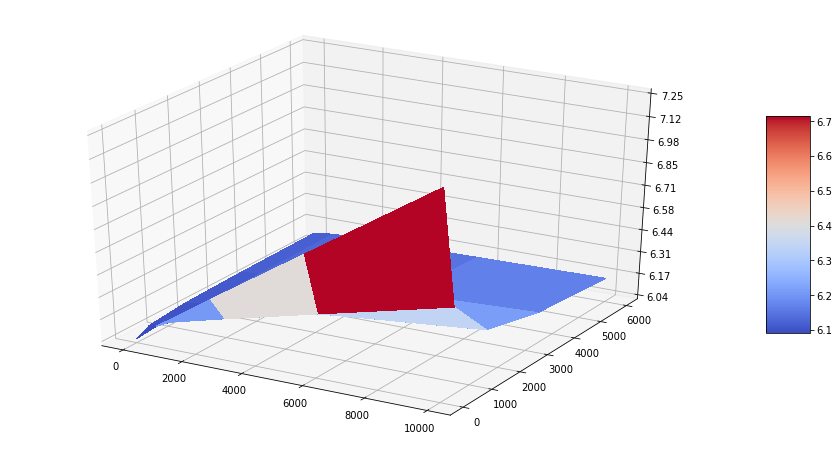

200
200


<Figure size 432x288 with 0 Axes>

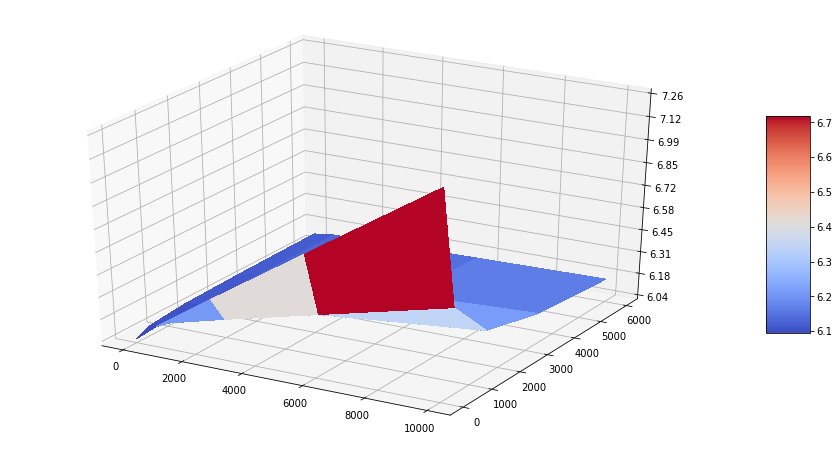

In [24]:
# Mortgage amount 
Ms = np.array([50, 100, 150, 200])
# Improvement amount 
gs = np.array([10, 20, 100, 200])
for i in range(len(Ms)):
    for j in range(len(gs)):
        print(Ms[i])
        print(Ms[j])
        plt.figure()  
        surfacePlot(xgrid[:,:,i,j,1,1,0], xgrid[:,:,i,j,1,1,1], Vgrid[:,:,i,j,1,1,t])
        plt.show()

In [ ]:
plt.plot(cgrid[4,3,2,2,1,1,:69])

In [ ]:
plt.plot(bgrid[4,3,2,2,1,1,:69])

In [ ]:
plt.plot(kgrid[4,3,2,2,1,1,:69])

In [ ]:
plt.plot(igrid[4,3,2,2,1,1,:69])

In [ ]:
plt.plot(qgrid[4,3,2,2,1,1,:69])